In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:
from tensorflow.keras.layers import Input, Reshape, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

def MDFF_1():
    init = Input((224, 224, 3))
    x = Reshape((224 * 224, 3))(init) 

    x = Conv1D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x) 

    x = Conv1D(256, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(512, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(512, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = GlobalAveragePooling1D()(x) 

    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x) 
    
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    output_f1_5 = Dense(512, activation='relu')(x)

    return init, output_f1_5

import tensorflow as tf
from tensorflow.keras.layers import Reshape, Permute

def channel_shuffle(x, groups):

    batch, height, width, channels = x.shape.as_list()
    channels_per_group = channels // groups
    x = Reshape((height, width, groups, channels_per_group))(x)

    x = Permute((1, 2, 4, 3))(x)
    x = Reshape((height, width, channels))(x)
    return x

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Add, Concatenate

def PMS(input_feature):
    C = input_feature.shape[-1]
    groups = 4  

    x1 = Conv2D(C // 4, (1, 1), padding='same')(input_feature) 
    x1 = BatchNormalization()(x1) 
    x1 = channel_shuffle(x1, groups) 
    x1 = DepthwiseConv2D((3, 3), padding='same')(x1) 
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(C, (1, 1), padding='same')(x1)
    x1_out = Add()([x1, input_feature]) 

    x2 = Conv2D(C // 4, (1, 1), padding='same')(input_feature)
    x2 = BatchNormalization()(x2)
    x2 = channel_shuffle(x2, groups) 
    x2 = DepthwiseConv2D((5, 5), padding='same')(x2) 
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(C, (1, 1), padding='same')(x2)
    x2_out = Add()([x2, input_feature]) 

    merged = Concatenate(axis=-1)([x1_out, x2_out])
    adjusted = Conv2D(C, (3, 3), padding='same')(merged) 
    res = Add()([adjusted, input_feature])
    output = Activation('relu')(res) 
    
    return output

def MSAmodule(init):
    
    x = PMS(init)
    x = PMS(x)
    x = PMS(x)
    x = PMS(x)
    top_path = Activation('sigmoid')(x)
    y = GlobalAveragePooling2D()(init)
    C = init.shape[-1]
    y = Reshape((1, 1, C))(y)
    y = Conv2D(C // 4, (1, 1), activation='relu', padding='same')(y)
    y = Conv2D(C, (1, 1), activation='sigmoid', padding='same')(y)
    bottom_path = Multiply()([init, y])
    combined = Add()([top_path, bottom_path])
    output = Activation('relu')(combined)
    
    return output

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Flatten, Dense
def MDFF_2():
    init = Input((224, 224, 3))
    
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(init)
    p1 = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x1) 
    msa1 = MSAmodule(p1)
    c1 = Concatenate()([p1, msa1]) 

    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p2 = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x2) 
    msa2 = MSAmodule(p2)
    
    p1_down_to_56 = MaxPooling2D((2, 2))(p1) 
    
    c2 = Concatenate()([p2, msa2, p1_down_to_56]) 

    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p3 = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x3) 
    msa3 = MSAmodule(p3)
    
    p2_down_to_28 = MaxPooling2D((2, 2))(p2)
    p1_down_to_28 = MaxPooling2D((4, 4))(p1) 
    
    c3 = Concatenate()([p3, msa3, p2_down_to_28, p1_down_to_28])

    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p4 = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x4) 
    msa4 = MSAmodule(p4)
    
    p3_down_to_14 = MaxPooling2D((2, 2))(p3)
    p2_down_to_14 = MaxPooling2D((4, 4))(p2)
    p1_down_to_14 = MaxPooling2D((8, 8))(p1) 
    
    c4 = Concatenate()([p4, msa4, p3_down_to_14, p2_down_to_14, p1_down_to_14])

    gap = GlobalAveragePooling2D()(c4)
    flat = Flatten()(gap) 
    output_f2_5 = Dense(512, activation='relu')(flat) 

    return init, output_f2_5

from tensorflow.keras.layers import Concatenate, Dense, Activation
from tensorflow.keras.models import Model

def MDFF_Net_Final(output_f1_5, output_f2_5, num_classes=4):

    fused_features = Concatenate(axis=-1)([output_f1_5, output_f2_5])
    x = Dense(512, activation='relu')(fused_features)
    predictions = Dense(num_classes, activation='softmax')(x)

    return predictions

input_1d, feat_1d = MDFF_1() 
input_2d, feat_2d = MDFF_2() 
preds = MDFF_Net_Final(feat_1d, feat_2d, num_classes=4)

model = Model(inputs=[input_1d, input_2d], outputs=preds)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 8)  264         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [5]:
def dual_input_generator(generator):
 
    for x, y in generator:
        yield [x, x], y

In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mdff_net_best.keras',
        monitor='val_accuracy',
        save_best_only=True, 
        verbose=1
    )
]
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size
history = model.fit(
    dual_input_generator(train_generator),
    epochs=65, 
    steps_per_epoch=steps_per_epoch,
    validation_data=dual_input_generator(val_generator),
    validation_steps=validation_steps,
    callbacks=callbacks
)

model.save('mdff_net_prostate_classification.h5') 
print("Model saved successfully as h5 file.")


Epoch 1/65
416/416 [==============================] - 480s 1s/step - loss: 0.8669 - accuracy: 0.6191 - val_loss: 1.1083 - val_accuracy: 0.4858

Epoch 00001: val_accuracy improved from -inf to 0.48582, saving model to mdff_net_best.keras


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/65
416/416 [==============================] - 464s 1s/step - loss: 0.7304 - accuracy: 0.6738 - val_loss: 0.6562 - val_accuracy: 0.7064

Epoch 00002: val_accuracy improved from 0.48582 to 0.70641, saving model to mdff_net_best.keras
Epoch 3/65
416/416 [==============================] - 461s 1s/step - loss: 0.6364 - accuracy: 0.7188 - val_loss: 0.5964 - val_accuracy: 0.7421

Epoch 00003: val_accuracy improved from 0.70641 to 0.74212, saving model to mdff_net_best.keras
Epoch 4/65
416/416 [==============================] - 462s 1s/step - loss: 0.6067 - accuracy: 0.7399 - val_loss: 0.6793 - val_accuracy: 0.6712

Epoch 00004: val_accuracy did not improve from 0.74212
Epoch 5/65
416/416 [==============================] - 462s 1s/step - loss: 0.5723 - accuracy: 0.7520 - val_loss: 0.7076 - val_accuracy: 0.6912

Epoch 00005: val_accuracy did not improve from 0.74212
Epoch 6/65
416/416 [==============================] - 462s 1s/step - loss: 0.5418 - accuracy: 0.7617 - val_loss: 1.3041 - 

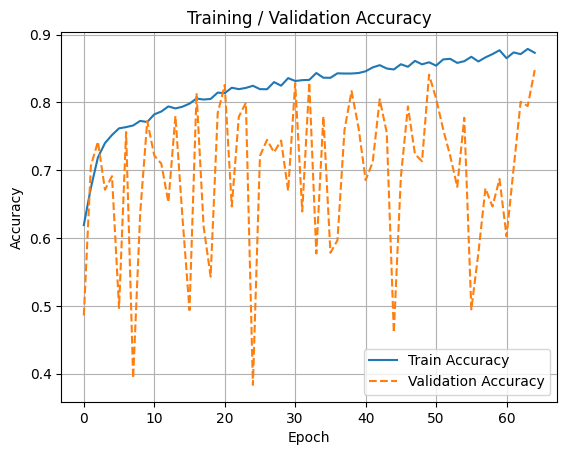

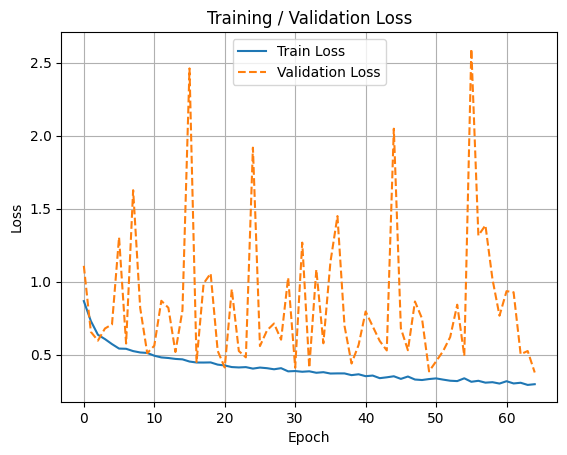

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.title('Training / Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '--')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training / Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [13]:
def dual_input_generator(generator):
    for x, y in generator:
        yield [x, x], y

test_steps = test_generator.samples // test_generator.batch_size

Y_pred = model.predict(
    dual_input_generator(test_generator),
    steps=test_steps
)

y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.labels[:len(y_pred)]


In [14]:
n = len(y_pred)
y_true = test_generator.labels[:n]
from sklearn.metrics import *

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred, average="macro"))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("Jaccard:", jaccard_score(y_true, y_pred, average="macro"))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.7314017227877838
F1: 0.6823887959737083
Precision: 0.7002669451051581
Recall: 0.6757694003928486
Jaccard: 0.5332116387324036

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       466
           1       0.63      0.46      0.53       233
           2       0.66      0.82      0.73       411
           3       0.62      0.58      0.60       167

    accuracy                           0.73      1277
   macro avg       0.70      0.68      0.68      1277
weighted avg       0.73      0.73      0.73      1277

Confusion Matrix:
 [[394  45  27   0]
 [  0 107 123   3]
 [  0  19 336  56]
 [ 47   0  23  97]]


In [ ]:
class_names = list(test_generator.class_indices.keys())
print(class_names)
for i in range(10):   
    print("True:", class_names[y_true[i]], 
          "Pred:", class_names[y_pred[i]])
for i in range(5):
    print("Image", i)
    for j, cls in enumerate(class_names):
        print(f"  {cls}: {Y_pred[i][j]:.4f}")


['A', 'B', 'C', 'D']
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
True: A Pred: A
Image 0
  A: 1.0000
  B: 0.0000
  C: 0.0000
  D: 0.0000
Image 1
  A: 1.0000
  B: 0.0000
  C: 0.0000
  D: 0.0000
Image 2
  A: 1.0000
  B: 0.0000
  C: 0.0000
  D: 0.0000
Image 3
  A: 1.0000
  B: 0.0000
  C: 0.0000
  D: 0.0000
Image 4
  A: 1.0000
  B: 0.0000
  C: 0.0000
  D: 0.0000
